In [1]:
import transformers

In [2]:
#pip install torch torchvision torchaudio

In [3]:
from transformers import pipeline
classifier = pipeline('summarization')

Init Plugin
Init Graph Optimizer
Init Kernel


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [4]:
classifier('Cinderella came from a great family. She is the only daughter of an affluent and widower duke who has rewed to provide her with a stepmom and two stepsisters. Cinderellas mother died due to illness when she was still a young girl, leaving her with a doll, favorite dress, and a pair of glass slippers.')

Your max_length is set to 142, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


[{'summary_text': ' Cinderella is the only daughter of an affluent and widower duke who has rewed to provide her with a stepmom and two stepsisters . Cinderellas mother died due to illness when she was still a young girl, leaving a doll, favorite dress, and a pair of glass slippers .'}]

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [6]:
model_name = "dslim/bert-large-NER"
# This model only exists in PyTorch, so we use the `from_pt` flag to import that model in TensorFlow.
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
#classifier = pipeline('', model=model, tokenizer=tokenizer)

Metal device set to: Apple M1


2021-12-22 21:32:59.441595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-22 21:32:59.442022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [7]:
import pandas as pd
#data = pd.read_csv('/Users/cosmos/Desktop/DeepBlue/BACKEND/Datasets/Main/resume_dataset.csv')
#data.head(10)


In [9]:
#data.shape

In [10]:
import json
import re

data = pd.read_json("NER_RESUME.json", lines = True)
data.head(5)

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [11]:
data.shape

(220, 3)

In [12]:
#data preprocessing


data["content"] = data["content"].apply(lambda x: x.replace("\n", " "))
data["content"].head(5)


0    Abhishek Jha Application Development Associate...
1    Afreen Jamadar Active member of IIIT Committee...
2    Akhil Yadav Polemaina Hyderabad, Telangana - E...
3    Alok Khandai Operational Analyst (SQL DBA) Eng...
4    Ananya Chavan lecturer - oracle tutorials  Mum...
Name: content, dtype: object

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     220 non-null    object 
 1   annotation  220 non-null    object 
 2   extras      0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 5.3+ KB


In [14]:
# import logging
import json
import re

# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    lines=[]
    with open(dataturks_JSON_FilePath, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = json.loads(line)
        text = data['content'].replace("\n", " ")
        entities = []
        data_annotations = data['annotation']
        if data_annotations is not None:
            for annotation in data_annotations:
                #only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                # handle both list of labels or a single label.
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    point_start = point['start']
                    point_end = point['end']
                    point_text = point['text']

                    lstrip_diff = len(point_text) - len(point_text.lstrip())
                    rstrip_diff = len(point_text) - len(point_text.rstrip())
                    if lstrip_diff != 0:
                        point_start = point_start + lstrip_diff
                    if rstrip_diff != 0:
                        point_end = point_end - rstrip_diff
                    entities.append((point_start, point_end + 1 , label))
        training_data.append((text, {"entities" : entities}))
    return training_data

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [15]:
data = trim_entity_spans(convert_dataturks_to_spacy("NER_RESUME.json"))
data[0]

["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [16]:
#Overlapping Entities

In [17]:
def clean_entities(training_data):
    
    clean_data = []
    for text, annotation in training_data:
        
        entities = annotation.get('entities')
        entities_copy = entities.copy()
        
        # append entity only if it is longer than its overlapping entity
        i = 0
        for entity in entities_copy:
            j = 0
            for overlapping_entity in entities_copy:
                # Skip self
                if i != j:
                    e_start, e_end, oe_start, oe_end = entity[0], entity[1], overlapping_entity[0], overlapping_entity[1]
                    # Delete any entity that overlaps, keep if longer
                    if ((e_start >= oe_start and e_start <= oe_end) \
                    or (e_end <= oe_end and e_end >= oe_start)) \
                    and ((e_end - e_start) <= (oe_end - oe_start)):
                        entities.remove(entity)
                j += 1
            i += 1
        clean_data.append((text, {'entities': entities}))
                
    return clean_data

data = clean_entities(data)

In [20]:
#pip install nltk

In [23]:
# Changing data to appropriate format so as to feed it to the model
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

df_data = pd.DataFrame(columns = ["clean_content", "entities_mapped"])

entities_mapped = []
clean_content = []

for i in range(len(data)):
    content = data[i][0].split()
    entities = data[i][1]["entities"]
    words = []
    labels = []
    
    for word in content:
        if (word.isalnum() or word.find(".com") != -1) and word not in en_stops:
            words.append(word)
            found = False
            for entity in sorted(entities):
                ent_start = entity[0]
                ent_end = entity[1]
                ent_label = entity[2]

                if word in data[i][0][ent_start: ent_end].split(): 
                    labels.append(ent_label)
                    found = True
                    break
            if not found:
                labels.append("O")
    
    entities_mapped.append(labels)
    clean_content.append(words)
    
    
df_data["entities_mapped"] = entities_mapped
df_data["clean_content"] = clean_content
df_data["clean_content"] = df_data["clean_content"].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cosmos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df_data.head(5)

,clean_content,entities_mapped
0,Abhishek Jha Application Development Associate...,"[Name, Name, Designation, Designation, Designa..."
1,Afreen Jamadar Active member IIIT Committee Th...,"[Name, Name, O, O, O, O, O, O, O, O, Email Add..."
2,Akhil Yadav Polemaina Telangana Email indeed.c...,"[Name, Name, Name, O, O, Email Address, Email ..."
3,Alok Khandai Operational Analyst Engineer UNIS...,"[Name, Name, Designation, Designation, Designa..."
4,Ananya Chavan lecturer oracle tutorials Mahara...,"[Name, Name, Designation, Companies worked at,..."


In [27]:
df_data["clean_content"]

0      Abhishek Jha Application Development Associate...
1      Afreen Jamadar Active member IIIT Committee Th...
2      Akhil Yadav Polemaina Telangana Email indeed.c...
3      Alok Khandai Operational Analyst Engineer UNIS...
4      Ananya Chavan lecturer oracle tutorials Mahara...
                             ...                        
215    Mansi Thanki Student Gujarat Email indeed.com/...
216    Anil Kumar Microsoft Azure Delhi Email indeed....
217    Siddharth Choudhary Microsoft Office Suite Exp...
218    Valarmathi Dhandapani Investment Banking Karna...
219    Pradeep Kumar Security Analyst Infosys Career ...
Name: clean_content, Length: 220, dtype: object

In [29]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clean_content    220 non-null    object
 1   entities_mapped  220 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


In [30]:
n_labels = len(set([e for entity in df_data["entities_mapped"].values for e in entity]))
print(n_labels)

12


In [31]:
df_data.to_csv("cleaned_resume.csv")

<AxesSubplot:ylabel='Frequency'>

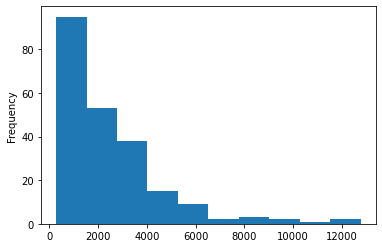

In [32]:
df_data['clean_content'].apply(len).plot(kind = 'hist')